In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [3]:
dataDirectory = '/home/h1bennet/strains/data/PU1/'
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_PU1/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


### Make output directory

In [4]:
if not os.path.isdir('./peak_heatmaps/'):
    os.mkdir('./peak_heatmaps/')

# Read in differential H3K27Ac-seq data

In [5]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_idr_peaks_merged.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (51430, 22)
getDiffExpression selected transcripts (50443, 25)
annotatePeaks selected peaks (50443, 22)


Pull intersection and union peaks

In [7]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['c57',
         'balbc']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        # peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing c57 ...

0
For comp: 00_balbc vs. 01_c57
Union set at: 1057 peaks
Intersection set at: 1057 peaks

Analyzing balbc ...

0
For comp: 00_balbc vs. 01_c57
Union set at: 925 peaks
Intersection set at: 925 peaks



### Extract each union set and sort by peak score

In [8]:
for key in peak_lists.keys():
    diff_peak.loc[peak_lists[key], :].sort_values('Peak Score', ascending=False).to_csv(
    './peak_heatmaps/'+key+'pu1_peaks.txt', sep='\t')

### Annotate with H3K27Ac-seq tags

In [11]:
os.listdir(dataDirectory+'/control/')

['mouse_C57Bl6_M_KupfferTim4Pos_ChIP_PU1_NoTx_JSSTDT_PC231A_JSS_l20180201_concat',
 'balb_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_BALB10ABC_TDT_l20170915',
 'balbcj_M_KupfferTim4Pos_PU1_ChIP_notx_TDTJSS_BALB11AB_s20161208',
 'c57bl6j_Male_Tim4PosKupffer_ChIP_PU1_notx_TDTJSS_Pool_l20180423',
 'aj_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_AJ10ABC_TDT_l20170915']

In [14]:
with open('./annotate_peak_heatmaps.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./peak_heatmaps/*peaks.txt')):
        heatmap = peakfile.replace('_peaks.txt', '_3kb_ghist.txt')
        call = ['annotatePeaks.pl', peakfile,
                'mm10 -size 3000 -hist 50 -ghist -d \\\n',
                dataDirectory+'control/balb_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_BALB10ABC_TDT_l20170915 \\\n',
                dataDirectory+'control/balbcj_M_KupfferTim4Pos_PU1_ChIP_notx_TDTJSS_BALB11AB_s20161208 \\\n',
                dataDirectory+'control/c57bl6j_Male_Tim4PosKupffer_ChIP_PU1_notx_TDTJSS_Pool_l20180423 \\\n',
                dataDirectory+'control/mouse_C57Bl6_M_KupfferTim4Pos_ChIP_PU1_NoTx_JSSTDT_PC231A_JSS_l20180201_concat \\\n',
                '>', heatmap, '\n\n']
        f.write(' '.join(call))

./figures/pu1_heatmap_balbc_intersectionpu1_3kb_ghist.png
./figures/pu1_heatmap_c57_intersectionpu1_3kb_ghist.png


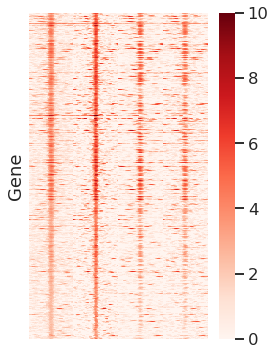

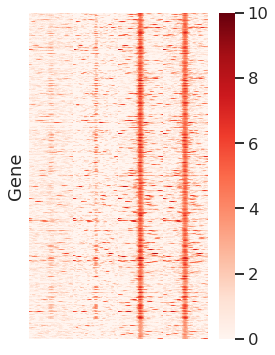

In [15]:
for i in np.sort(glob.glob('./peak_heatmaps/*ghist.txt')):
    figpath = i.replace('peak_heatmaps/', 'figures/pu1_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    fig, ax = plt.subplots(figsize=(4,6))
    sns.heatmap(np.log2(df+1),
            cmap='Reds',
            # cbar_kws={'label':'Normalized\nTag Density'},
            vmax=10,
            xticklabels=0,
            yticklabels=0,
            ax=ax)
    
    print(figpath)
    plt.savefig(figpath)